In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


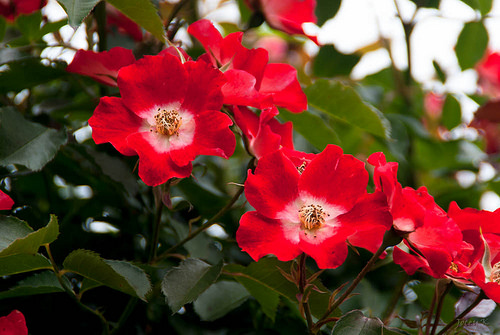

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

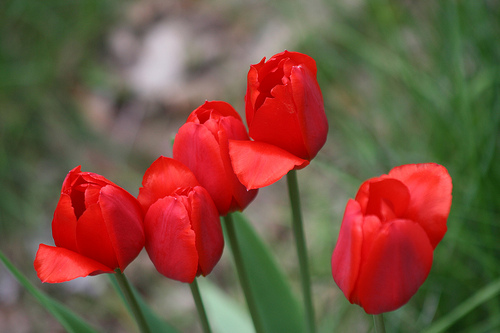

In [31]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


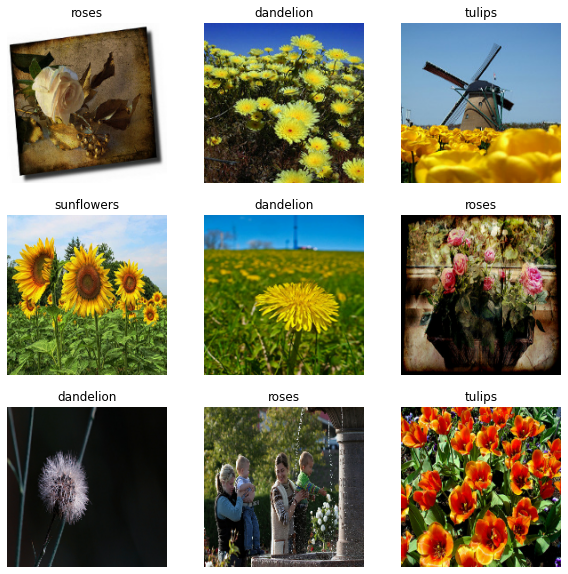

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The tensor size `(32,180,180,3)` indicates 32 images, each of `180x180x3` dimension.

## Configure the dataset for performance

Use buffered prefetching so yield data from disk without having I/O become blocking.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training model.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; make your input values small- standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9970691


# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. 

In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Training  model

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 11s 38ms/step - loss: 1.4122 - accuracy: 0.4068 - val_loss: 1.0653 - val_accuracy: 0.5681
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 1.0071 - accuracy: 0.5997 - val_loss: 0.9334 - val_accuracy: 0.6185
Epoch 3/10
92/92 [==============================] - 2s 19ms/step - loss: 0.7887 - accuracy: 0.6983 - val_loss: 0.8682 - val_accuracy: 0.6390
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.5896 - accuracy: 0.7788 - val_loss: 0.8398 - val_accuracy: 0.6744
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.3848 - accuracy: 0.8619 - val_loss: 0.9397 - val_accuracy: 0.6812
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.2205 - accuracy: 0.9393 - val_loss: 1.0977 - val_accuracy: 0.6608
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1209 - accuracy: 0.9643 - val_loss: 1.4236 - val_accuracy: 0.6499
Epoch 8/10
9

## Visualize training results

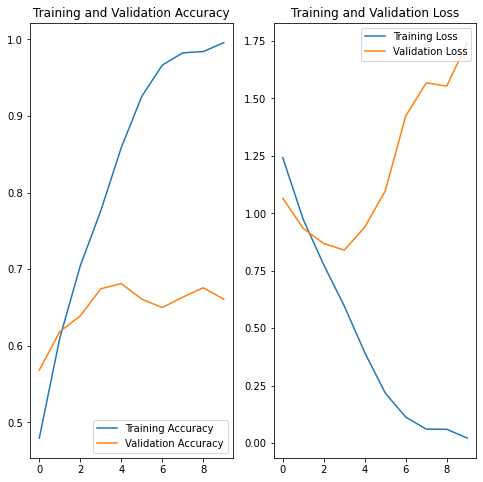

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

Use *data augmentation* and add *Dropout* to model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation - approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

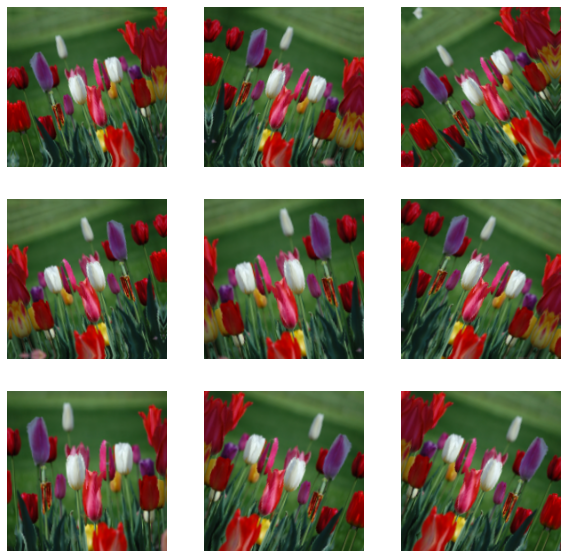

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Another technique to reduce overfitting is to introduce Dropout to the network, a form of *regularization*.

Applying Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. 

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 3s 28ms/step - loss: 1.6821 - accuracy: 0.3077 - val_loss: 1.1499 - val_accuracy: 0.5327
Epoch 2/15
92/92 [==============================] - 2s 26ms/step - loss: 1.1071 - accuracy: 0.5570 - val_loss: 0.9963 - val_accuracy: 0.6008
Epoch 3/15
92/92 [==============================] - 2s 26ms/step - loss: 0.9400 - accuracy: 0.6308 - val_loss: 0.9122 - val_accuracy: 0.6444
Epoch 4/15
92/92 [==============================] - 2s 26ms/step - loss: 0.8277 - accuracy: 0.6875 - val_loss: 0.8278 - val_accuracy: 0.6853
Epoch 5/15
92/92 [==============================] - 2s 26ms/step - loss: 0.8454 - accuracy: 0.6848 - val_loss: 0.8332 - val_accuracy: 0.6662
Epoch 6/15
92/92 [==============================] - 2s 26ms/step - loss: 0.7972 - accuracy: 0.6970 - val_loss: 0.7560 - val_accuracy: 0.7044
Epoch 7/15
92/92 [==============================] - 2s 26ms/step - loss: 0.7176 - accuracy: 0.7235 - val_loss: 0.7963 - val_accuracy: 0.6935
Epoch 8/15
92

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

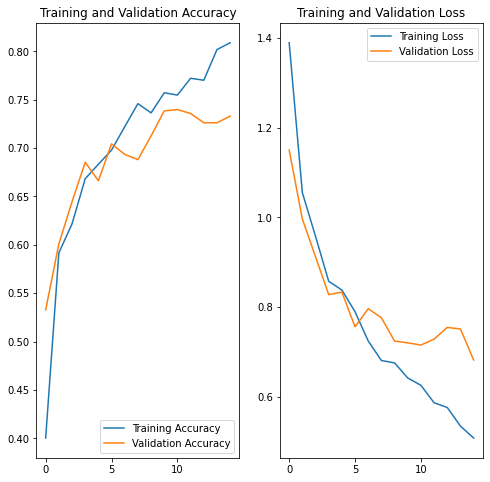

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [33]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

In [39]:
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 98.89 percent confidence.


$ BY Gaurav Kabra$

`Adapted from` : [Tensorflow](https://www.tensorflow.org/tutorials/images/classification)